In [3]:
!pip install tensorflow==1.15

  Using cached gast-0.2.2.tar.gz (10 kB)
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7548 sha256=d04d7dbd60e6d90a0a77be405ecf4e776ccfe570855d5433732059c8bab91344
  Stored in directory: c:\users\kongpasom\appdata\local\pip\cache\wheels\19\a7\b9\0740c7a3a7d1d348f04823339274b90de25fbcd217b2ee1fbe
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Attempting uninstall: gast
    Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.3.0rc0
    Uninstalling tensorflow-2.3.0rc0:
      S

In [1]:
#!curl -O https://storage.googleapis.com/nasbench/nasbench_only108.tfrecord
#!curl -O https://storage.googleapis.com/nasbench/nasbench_full.tfrecord

# Clone and install the code and dependencies.

# !git clone https://github.com/google-research/nasbench
# !pip install ./nasbench

# Initialize the NASBench object which parses the raw data into memory (this
# should only be run once as it takes up to a few minutes).
from nasbench import api

# Use nasbench_full.tfrecord for full dataset (run download command above).
nasbench = api.NASBench('nasbench_full.tfrecord')

W0413 23:15:46.496694 10920 module_wrapper.py:139] From C:\Users\kongpasom\AppData\Local\Programs\Python\Python36\lib\site-packages\nasbench\lib\training_time.py:130: The name tf.train.SessionRunHook is deprecated. Please use tf.estimator.SessionRunHook instead.

W0413 23:15:46.499691 10920 module_wrapper.py:139] From C:\Users\kongpasom\AppData\Local\Programs\Python\Python36\lib\site-packages\nasbench\lib\training_time.py:174: The name tf.train.CheckpointSaverListener is deprecated. Please use tf.estimator.CheckpointSaverListener instead.

W0413 23:15:46.500692 10920 module_wrapper.py:139] From C:\Users\kongpasom\AppData\Local\Programs\Python\Python36\lib\site-packages\nasbench\lib\evaluate.py:30: The name tf.train.NanLossDuringTrainingError is deprecated. Please use tf.estimator.NanLossDuringTrainingError instead.

W0413 23:15:46.519694 10920 deprecation.py:323] From C:\Users\kongpasom\AppData\Local\Programs\Python\Python36\lib\site-packages\nasbench\api.py:146: tf_record_iterator (fr

Loading dataset from file... This may take a few minutes...
Loaded dataset in 233 seconds


In [2]:
# Standard imports
import copy
import numpy as np
import matplotlib.pyplot as plt
import random

# Useful constants
INPUT = 'input'
OUTPUT = 'output'
CONV3X3 = 'conv3x3-bn-relu'
CONV1X1 = 'conv1x1-bn-relu'
MAXPOOL3X3 = 'maxpool3x3'
NUM_VERTICES = 7
MAX_EDGES = 9
EDGE_SPOTS = NUM_VERTICES * (NUM_VERTICES - 1) / 2   # Upper triangular matrix
OP_SPOTS = NUM_VERTICES - 2   # Input/output vertices are fixed
ALLOWED_OPS = [CONV3X3, CONV1X1, MAXPOOL3X3]
ALLOWED_EDGES = [0, 1]   # Binary adjacency matrix

In [3]:
# Query an Inception-like cell from the dataset.
cell = api.ModelSpec(
  matrix=[[0, 1, 1, 1, 0, 1, 0],    # input layer
          [0, 0, 0, 0, 0, 0, 1],    # 1x1 conv
          [0, 0, 0, 0, 0, 0, 1],    # 3x3 conv
          [0, 0, 0, 0, 1, 0, 0],    # 5x5 conv (replaced by two 3x3's)
          [0, 0, 0, 0, 0, 0, 1],    # 5x5 conv (replaced by two 3x3's)
          [0, 0, 0, 0, 0, 0, 1],    # 3x3 max-pool
          [0, 0, 0, 0, 0, 0, 0]],   # output layer
  # Operations at the vertices of the module, matches order of matrix.
  ops=[INPUT, CONV1X1, CONV3X3, CONV3X3, CONV3X3, MAXPOOL3X3, OUTPUT])

# Querying multiple times may yield different results. Each cell is evaluated 3
# times at each epoch budget and querying will sample one randomly.
data = nasbench.query(cell)
for k, v in data.items():
  print('%s: %s' % (k, str(v)))

module_adjacency: [[0 1 1 1 1 0 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0]]
module_operations: ['input', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'maxpool3x3', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'output']
trainable_parameters: 2694282
training_time: 1157.675048828125
train_accuracy: 1.0
validation_accuracy: 0.9378004670143127
test_accuracy: 0.932692289352417


In [4]:
def random_spec():
  """Returns a random valid spec."""
  while True:
    matrix = np.random.choice(ALLOWED_EDGES, size=(NUM_VERTICES, NUM_VERTICES))
    matrix = np.triu(matrix, 1)
    ops = np.random.choice(ALLOWED_OPS, size=(NUM_VERTICES)).tolist()
    ops[0] = INPUT
    ops[-1] = OUTPUT
    spec = api.ModelSpec(matrix=matrix, ops=ops)
    if nasbench.is_valid(spec):
      return spec

def mutate_spec(old_spec, mutation_rate=1.0):
  """Computes a valid mutated spec from the old_spec."""
  while True:
    new_matrix = copy.deepcopy(old_spec.original_matrix)
    new_ops = copy.deepcopy(old_spec.original_ops)

    # In expectation, V edges flipped (note that most end up being pruned).
    edge_mutation_prob = mutation_rate / NUM_VERTICES
    for src in range(0, NUM_VERTICES - 1):
      for dst in range(src + 1, NUM_VERTICES):
        if random.random() < edge_mutation_prob:
          new_matrix[src, dst] = 1 - new_matrix[src, dst]
          
    # In expectation, one op is resampled.
    op_mutation_prob = mutation_rate / OP_SPOTS
    for ind in range(1, NUM_VERTICES - 1):
      if random.random() < op_mutation_prob:
        available = [o for o in nasbench.config['available_ops'] if o != new_ops[ind]]
        new_ops[ind] = random.choice(available)
        
    new_spec = api.ModelSpec(new_matrix, new_ops)
    if nasbench.is_valid(new_spec):
      return new_spec

def random_combination(iterable, sample_size):
  """Random selection from itertools.combinations(iterable, r)."""
  pool = tuple(iterable)
  n = len(pool)
  indices = sorted(random.sample(range(n), sample_size))
  return tuple(pool[i] for i in indices)

def run_random_search(max_time_budget=5e6):
  """Run a single roll-out of random search to a fixed time budget."""
  nasbench.reset_budget_counters()
  times, best_valids, best_tests = [0.0], [0.0], [0.0]
  while True:
    spec = random_spec()
    data = nasbench.query(spec)

    # It's important to select models only based on validation accuracy, test
    # accuracy is used only for comparing different search trajectories.
    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])

    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)
    if time_spent > max_time_budget:
      # Break the first time we exceed the budget.
      break

  return times, best_valids, best_tests

def run_evolution_search(max_time_budget=5e6,
                         population_size=100,
                         tournament_size=10,
                         mutation_rate=1.0,
                         ee = False,
                         ee_params = 24955436.046849795):
  """Run a single roll-out of regularized evolution to a fixed time budget."""
  nasbench.reset_budget_counters()
  times, best_valids, best_tests = [0.0], [0.0], [0.0]
  best_params = [0]
  population = []   # (validation, spec) tuples

  # For the first population_size individuals, seed the population with randomly
  # generated cells.
  while len(population) < population_size:
  #for _ in range(population_size):
    spec = random_spec()
    data = nasbench.query(spec)
    time_spent, _ = nasbench.get_budget_counters()
    if ee == True:
        #print(data['trainable_parameters'], ee_params, data['trainable_parameters'] < ee_params)
        if data['trainable_parameters'] <= ee_params :
            times.append(time_spent)
            population.append((data['validation_accuracy'], spec))
            
            if data['validation_accuracy'] > best_valids[-1]:
                best_valids.append(data['validation_accuracy'])
                best_tests.append(data['test_accuracy'])
                best_params.append(data['trainable_parameters'])
            else:
                best_valids.append(best_valids[-1])
                best_tests.append(best_tests[-1])
                best_params.append(best_params[-1])

            if time_spent > max_time_budget:
                break
    else:
        times.append(time_spent)
        population.append((data['validation_accuracy'], spec))
        
    if ee == False:
        if data['validation_accuracy'] > best_valids[-1]:
            best_valids.append(data['validation_accuracy'])
            best_tests.append(data['test_accuracy'])
            best_params.append(data['trainable_parameters'])
        else:
            best_valids.append(best_valids[-1])
            best_tests.append(best_tests[-1])
            best_params.append(best_params[-1])

        if time_spent > max_time_budget:
            break

  # After the population is seeded, proceed with evolving the population.
  while True:
    sample = random_combination(population, tournament_size)
    best_spec = sorted(sample, key=lambda i:i[0])[-1][1]
    new_spec = mutate_spec(best_spec, mutation_rate)

    data = nasbench.query(new_spec)
    time_spent, _ = nasbench.get_budget_counters()
    times.append(time_spent)

    # In regularized evolution, we kill the oldest individual in the population.
    population.append((data['validation_accuracy'], new_spec))
    population.pop(0)

    if data['validation_accuracy'] > best_valids[-1]:
      best_valids.append(data['validation_accuracy'])
      best_tests.append(data['test_accuracy'])
      best_params.append(data['trainable_parameters'])
    else:
      best_valids.append(best_valids[-1])
      best_tests.append(best_tests[-1])
      best_params.append(best_params[-1])

    if time_spent > max_time_budget:
      break

  return times, best_valids, best_tests, best_params
  

In [35]:
# Run random search and evolution search 10 times each. This should take a few
# minutes to run. Note that each run would have taken days of compute to
# actually train and evaluate if the dataset were not precomputed.
random_data = []
evolution_data = []
ee_evolution_data = []
avg_all = []
seed = 2020

import random
import tensorflow as tf

for repeat in range(10):
    tf.reset_default_graph()
    tf.random.set_random_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    print('Running repeat %d' % (repeat + 1))

    times, best_valid, best_test = run_random_search()
    random_data.append((times, best_valid, best_test))
    
    #times, best_valid, best_test = run_random_search()
    times, best_valid, best_test, best_params = run_evolution_search(ee=False)
    print(sum(best_params) / len(best_params))
    evolution_data.append((times, best_valid, best_test, best_params))

    times, best_valid, best_test, best_params = run_evolution_search(ee=True, ee_params = 2e7)
    print(sum(best_params) / len(best_params))
    ee_evolution_data.append((times, best_valid, best_test, best_params))
    seed = seed + 1

Running repeat 1
21628052.89112344
27435968.690958165
Running repeat 2
17044526.772594754
23825128.25639179
Running repeat 3
22574165.084546085
24661338.53319058
Running repeat 4
23468655.692255434
37321977.12059369
Running repeat 5
27113209.32142857
21337131.56645115
Running repeat 6
22225021.629224993
24623120.07029877
Running repeat 7
24251467.734679665
33771489.923856094
Running repeat 8
21515188.516040012
19081817.562856186
Running repeat 9
27381684.755991284
23409392.31884058
Running repeat 10
22988654.276291683
22517074.62186063


In [6]:
# plt.figure(figsize=(20, 5))

# plt.subplot(1, 3, 1)
# for times, best_valid, best_test in random_data:
#   plt.plot(times, best_valid, label='valid', color='red', alpha=0.5)
#   plt.plot(times, best_test, label='test', color='blue', alpha=0.5)

# plt.ylabel('accuracy')
# plt.xlabel('time spent (seconds)')
# plt.ylim(0.92, 0.96)
# plt.grid()
# plt.title('Random search trajectories (red=validation, blue=test)')


# plt.subplot(1, 3, 2)
# for times, best_valid, best_test in evolution_data:
#   plt.plot(times, best_valid, label='valid', color='red', alpha=0.5)
#   plt.plot(times, best_test, label='test', color='blue', alpha=0.5)

# plt.ylabel('accuracy')
# plt.xlabel('time spent (seconds)')
# plt.ylim(0.92, 0.96)
# plt.grid()
# plt.title('Evolution search trajectories (red=validation, blue=test)')

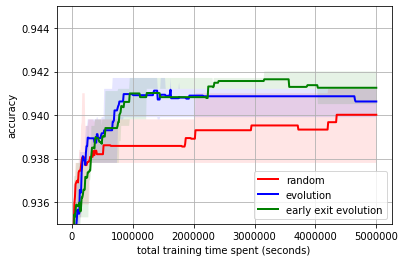

In [39]:
# Compare the mean test accuracy along with error bars.
def plot_data(data, color, label, gran=10000, max_budget=5000000):
  """Computes the mean and IQR fixed time steps."""
  xs = range(0, max_budget+1, gran)
  mean = [0.0]
  per25 = [0.0]
  per75 = [0.0]
  
  repeats = len(data)
  pointers = [1 for _ in range(repeats)]
  
  cur = gran
  while cur < max_budget+1:
    all_vals = []
    for repeat in range(repeats):
      while (pointers[repeat] < len(data[repeat][0]) and 
             data[repeat][0][pointers[repeat]] < cur):
        pointers[repeat] += 1
      prev_time = data[repeat][0][pointers[repeat]-1]
      prev_test = data[repeat][2][pointers[repeat]-1]
      next_time = data[repeat][0][pointers[repeat]]
      next_test = data[repeat][2][pointers[repeat]]
      assert prev_time < cur and next_time >= cur

      # Linearly interpolate the test between the two surrounding points
      cur_val = ((cur - prev_time) / (next_time - prev_time)) * (next_test - prev_test) + prev_test
      
      all_vals.append(cur_val)
      
    all_vals = sorted(all_vals)
    mean.append(sum(all_vals) / float(len(all_vals)))
    per25.append(all_vals[int(0.25 * repeats)])
    per75.append(all_vals[int(0.75 * repeats)])
      
    cur += gran
    
  plt.plot(xs, mean, color=color, label=label, linewidth=2)
  plt.fill_between(xs, per25, per75, alpha=0.1, linewidth=0, facecolor=color)

plot_data(random_data, 'red', 'random')
plot_data(evolution_data, 'blue', 'evolution')
plot_data(ee_evolution_data, 'green', 'early exit evolution')

plt.legend(loc='lower right')
plt.ylim(0.935, 0.945)
plt.xlabel('total training time spent (seconds)')
plt.ylabel('accuracy')
plt.grid()

In [27]:
def calculate_time_acc_max(data):
    max_valid = []
    max_test = []
    max_time = []
    max_params = []
    for data_ in data:
        max_time.append(max(data_[0]))
        max_valid.append(max(data_[1]))
        max_test.append(max(data_[2]))
        max_params.append(max(data_[3]))
    print(sum(max_time)/len(max_time))
    print(round(sum(max_valid)/len(max_valid)*100,2))
    print(round(sum(max_test)/len(max_test)*100,2))
    print(round(sum(max_params)/len(max_params),2))
calculate_time_acc_max(random_data)

5000792.008580017
94.93
94.24
29283146.0


In [28]:
calculate_time_acc_max(evolution_data)

5000939.390205383
95.0
94.26
33400406.8
